# Code to reproduce the experiments performed on the Ackley function

In [ ]:
import sys
sys.path.append("..")
sys.path.append("../..")

import numpy as np
import torch
from matplotlib import pyplot as plt
import json
import joblib
from numpy import arange

from inflation import *

from mpl_toolkits.mplot3d import Axes3D

import optuna
from torch.optim.optimizer import Optimizer, required

Define the function and print the global minimum

In [2]:
device = 'cpu'
n = 2

def ackley(xs):
    reg = 1e-8*(torch.norm(xs)**8)
    return -20*torch.exp(-.02*torch.sqrt((torch.norm(xs)**2)/n))-torch.exp(torch.sum(torch.cos(2*np.pi*xs))/n) +20+np.e+reg

global_min = torch.tensor([0.,0., 0., 0., 0.])[:n]
print(ackley(global_min))

xs = torch.tensor([-4.0,  3.0])

tensor(9.5367e-07)


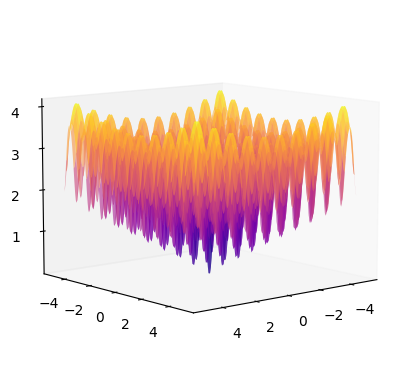

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate x, y values
x_values = np.linspace(-5, 5, 200)
y_values = np.linspace(-5, 5, 200)

# Initialize an empty array for z values
z_values = np.zeros((200, 200))

# Calculate z for each x, y pair
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        z_values[i, j] = ackley(torch.tensor([x, y]))

# Create a meshgrid for x and y values
X, Y = np.meshgrid(x_values, y_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(X, Y, z_values, cmap='plasma' , alpha=0.6)
ax.grid(False)
#ax.view_init(12, 45)

ax.view_init(9, 50)

plt.savefig("ackley.pdf", bbox_inches='tight')
plt.show()



In [4]:
#common parameters
tune_iterations = 200 
n_trials = 500 
test_iterations = 10*tune_iterations
deltaEn = 10
consEn = True

x0 = xs.tolist()
v0 = F0 =  1e-3
func = ackley

Optimization functions for each optimizer

In [5]:
def objective_ECDSep(trial):
    
    nu  = trial.suggest_float("nu", 1e-5, 1.0 )
    lr  = trial.suggest_float("lr", 1e-4, 1)
    eta = trial.suggest_float("eta", 1, 10)

    xs = torch.tensor(x0)
    xs.requires_grad=True
    optimizer = ECDSep([xs], lr=lr, nu = nu, F0 = F0, deltaEn = deltaEn, consEn = consEn, eta = eta, weight_decay = 0.0)

    minloss = np.inf
    for i in range(tune_iterations):
        optimizer.zero_grad()
        loss_fn=func(xs)
        if  loss_fn.item() < minloss: 
            minloss = loss_fn.item()
        loss_fn.backward()
        def closure():
                    return loss_fn
        optimizer.step(closure)
    return minloss

def objective_GDM(trial):
    
    lr  = trial.suggest_float("lr", 1e-8, 1e-3)
    momentum = trial.suggest_float("momentum", 0.8, 1)

    xs = torch.tensor(x0)
    xs.requires_grad=True
    optimizer = torch.optim.SGD([xs], lr=lr, momentum=momentum, weight_decay = 0.0)
    minloss = np.inf
    for i in range(tune_iterations):
        optimizer.zero_grad()
        loss_fn=func(xs)
        if  loss_fn.item() < minloss: 
            minloss = loss_fn.item()
        loss_fn.backward()
        def closure():
                    return loss_fn
        optimizer.step(closure)
    return minloss

def objective_Adam(trial):
    
    lr  = trial.suggest_float("lr", 1e-4, 1)
    beta1 = trial.suggest_float("beta1", 0.7, 1)
    beta2 = trial.suggest_float("beta2", 0.7, 1)
    eps = trial.suggest_float("eps", 1e-12, 1e-6)

    xs = torch.tensor(x0)
    xs.requires_grad=True
    optimizer = torch.optim.Adam([xs], lr=lr, betas=(beta1, beta2), weight_decay = 0.0)
    minloss = np.inf
    for i in range(tune_iterations):
        optimizer.zero_grad()
        loss_fn=func(xs)
        if  loss_fn.item() < minloss: 
            minloss = loss_fn.item()
        loss_fn.backward()
        def closure():
                    return loss_fn
        optimizer.step(closure)
    return minloss

## Tuning for each optimizer

ECDSep

In [ ]:
study_ECDSep = optuna.create_study()
study_ECDSep.optimize(objective_ECDSep, n_trials=n_trials)
best_params_ECDSep = study_ECDSep.best_params
print(best_params_ECDSep)
joblib.dump(study_ECDSep,"optuna-ackley-ECDSep.pkl")

Adam

In [ ]:
study_Adam = optuna.create_study()
study_Adam.optimize(objective_Adam, n_trials=n_trials)
best_params_Adam = study_Adam.best_params
print(best_params_Adam)
joblib.dump(study_Adam,"optuna-ackley-Adam.pkl")

GDM

In [ ]:
study_GDM = optuna.create_study()
study_GDM.optimize(objective_GDM, n_trials=n_trials)
best_params_GDM = study_GDM.best_params
print(best_params_GDM)
joblib.dump(study_GDM,"optuna-ackley-GDM.pkl")

## Runs with the best hyperparameters

In [9]:
print("Best hyperparameters for ECDSep")
print(best_params_ECDSep)

Best hyperparameters for ECDSep
{'nu': 0.5072722919129238, 'lr': 0.6978430924580129, 'eta': 1.0102203109384507}


In [10]:
print("Best hyperparameters for Adam")
print(best_params_Adam)

Best hyperparameters for Adam
{'lr': 0.9500469494874144, 'beta1': 0.9280965275549561, 'beta2': 0.9985324889463372, 'eps': 8.202145127963925e-07}


In [11]:
print("Best hyperparameters for GDM")
print(best_params_GDM)

Best hyperparameters for GDM
{'lr': 0.0007705675764663562, 'momentum': 0.9123637514861792}


Minimization with best parameters of ECDSep

In [12]:
x0 = torch.tensor([-4.0,  3.0])

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = ECDSep([xs], weight_decay = 0.0, **best_params_ECDSep, consEn = consEn, deltaEn = deltaEn, F0 = F0)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_ECDSep = losses

Minimization with best parameters of GDM

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = torch.optim.SGD([xs], weight_decay = 0.0, **best_params_GDM)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_GDM = losses

Minimization with best parameters of Adam

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
lr = best_params_Adam['lr']
betas = (best_params_Adam['beta1'],best_params_Adam['beta2'])
optimizer = torch.optim.Adam([xs], weight_decay = 0.0,lr = lr, betas = betas )
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_Adam = losses

Plot the results

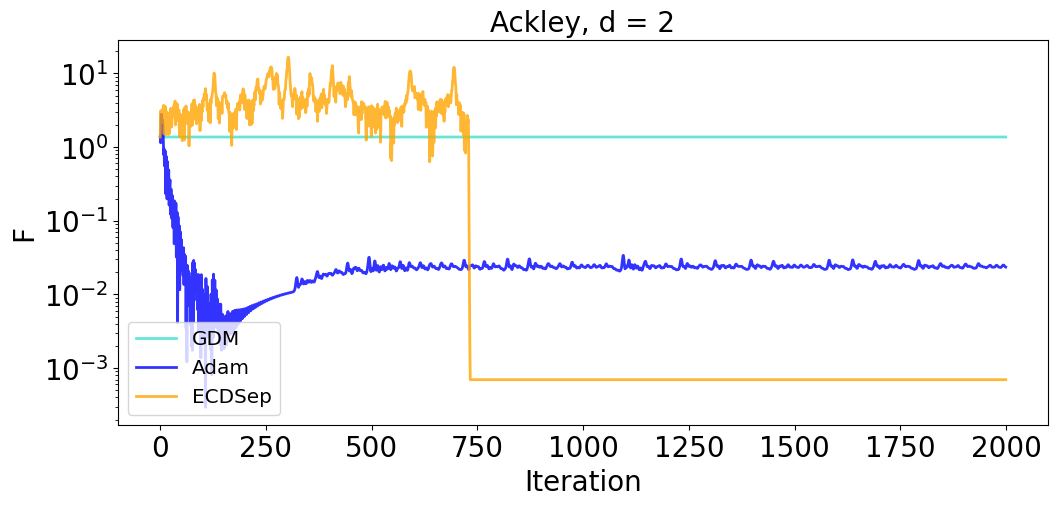

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(losses_GDM, label="GDM", alpha=.8, linewidth=2, color='turquoise')
plt.plot(losses_Adam, label="Adam", alpha = .8, linewidth=2, color='blue')
plt.plot(losses_ECDSep, label="ECDSep", alpha = .8, linewidth=2, color='orange')
plt.title('Ackley, d = '+str(2), fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('F', fontsize = 20)
plt.yscale('log')
plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('optuna-ackley.pdf',bbox_inches='tight')

## Different starting point

### Experiment 1

In [17]:
test_iterations = 2000
x0 = 3*torch.rand(2)

ECDSep

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = ECDSep([xs], weight_decay = 0.0, **best_params_ECDSep)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_ECDSep = losses

GDM

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = torch.optim.SGD([xs], weight_decay = 0.0, **best_params_GDM)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_GDM = losses

Adam

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
lr = best_params_Adam['lr']
betas = (best_params_Adam['beta1'],best_params_Adam['beta2'])
optimizer = torch.optim.Adam([xs], weight_decay = 0.0,lr = lr, betas = betas )
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_Adam = losses

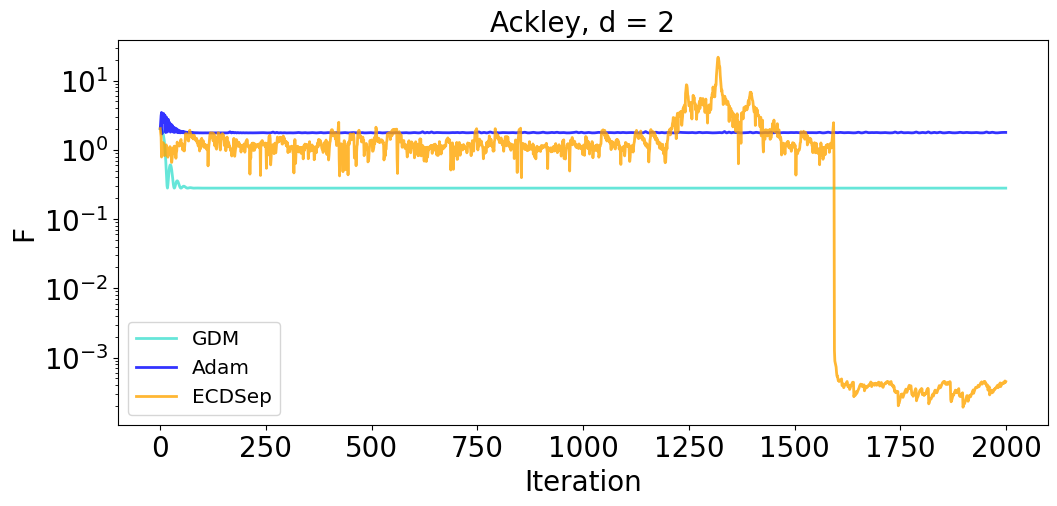

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(losses_GDM, label="GDM", alpha=.8, linewidth=2, color='turquoise')
plt.plot(losses_Adam, label="Adam", alpha = .8, linewidth=2, color='blue')
plt.plot(losses_ECDSep, label="ECDSep", alpha = .8, linewidth=2, color='orange')
plt.title('Ackley, d = '+str(2), fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('F', fontsize = 20)
plt.yscale('log')
plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('optuna-ackley2.pdf',bbox_inches='tight')

### Experiment 2

In [22]:
test_iterations = 2000
x0 = 3*torch.rand(2)

ECDSep

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = ECDSep([xs], weight_decay = 0.0, **best_params_ECDSep)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_ECDSep = losses

GDM

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
optimizer = torch.optim.SGD([xs], weight_decay = 0.0, **best_params_GDM)
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_GDM = losses

Adam

In [ ]:
xs = torch.tensor(x0)
xs.requires_grad=True
lr = best_params_Adam['lr']
betas = (best_params_Adam['beta1'],best_params_Adam['beta2'])
optimizer = torch.optim.Adam([xs], weight_decay = 0.0,lr = lr, betas = betas )
losses = []
for i in range(test_iterations):
    optimizer.zero_grad()
    loss_fn=func(xs)
    with torch.no_grad(): losses.append(loss_fn.item())
    loss_fn.backward()
    def closure():
                return loss_fn
    optimizer.step(closure)

losses_Adam = losses

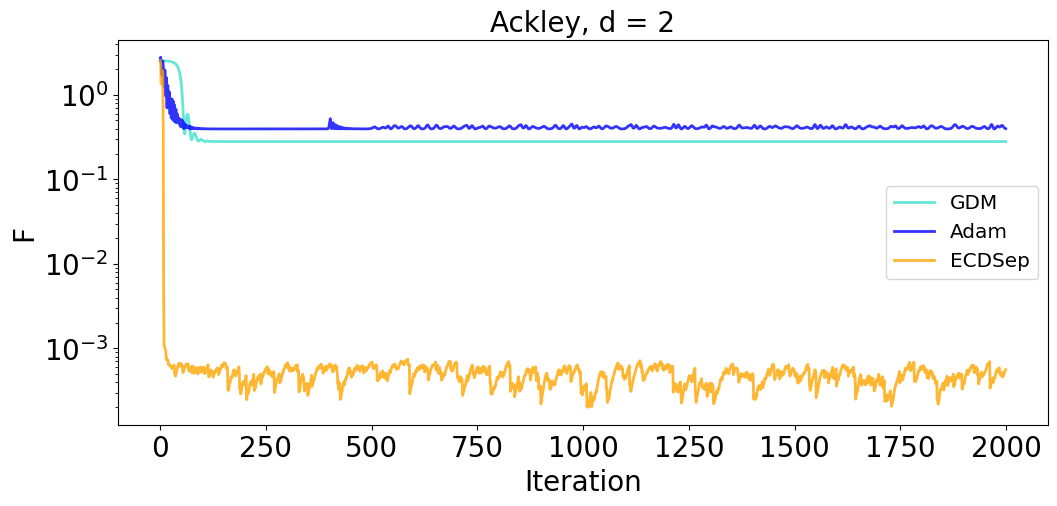

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(losses_GDM, label="GDM", alpha=.8, linewidth=2, color='turquoise')
plt.plot(losses_Adam, label="Adam", alpha = .8, linewidth=2, color='blue')
plt.plot(losses_ECDSep, label="ECDSep", alpha = .8, linewidth=2, color='orange')
plt.title('Ackley, d = '+str(2), fontsize = 20)
plt.xlabel('Iteration', fontsize = 20)
plt.ylabel('F', fontsize = 20)
plt.yscale('log')
plt.legend(loc='best', shadow=False, fontsize='x-large')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('optuna-ackley3.pdf',bbox_inches='tight')